In [ ]:
import sys
import os
sys.path.append('..')

from langchain_core.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableParallel, RunnableLambda, Runnable
from src.utils import RandomNameGenerator, save_to_json, load_from_json, assign_ids, LLMChatModule

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser, ListOutputParser
from tqdm.notebook import tqdm
from operator import itemgetter

from importlib import import_module
from datetime import datetime

# Display classes

In [2]:
example_data = [
    [
        {
            "title": "Introduction to AI",
            "subtitle": "Basics of Artificial Intelligence",
            "description": "This section covers the fundamental concepts of AI.",
            "concepts": str(["Machine Learning", "Neural Networks", "Deep Learning"])
        },
        {
            "title": "Advanced AI Techniques",
            "subtitle": "In-depth AI Methods",
            "description": "This section delves into advanced AI techniques.",
            "concepts": str(["Reinforcement Learning", "Generative Adversarial Networks", "Natural Language Processing"])
        }
    ],
    [
        {
            "title": "AI in Practice",
            "subtitle": "Real-world Applications",
            "description": "This section explores practical applications of AI.",
            "concepts": str(["Autonomous Vehicles", "AI in Healthcare", "AI in Finance"])
        },
        {
            "title": "Ethics in AI",
            "subtitle": "Moral Implications",
            "description": "This section discusses the ethical considerations of AI.",
            "concepts": str(["Bias in AI", "AI and Privacy", "AI and Employment"])
        }
    ]
]

new_example_data = [
    [
        {
            "title": "Introduction to Prompt Engineering",
            "subtitle": "Basics of Prompt Design",
            "description": "This section covers the fundamental concepts of prompt engineering.",
            "concepts": str(["Prompt Templates", "Prompt Variables", "Prompt Tuning"])
        },
        {
            "title": "Advanced Prompt Techniques",
            "subtitle": "In-depth Prompt Methods",
            "description": "This section delves into advanced prompt engineering techniques.",
            "concepts": str(["Dynamic Prompts", "Prompt Chaining", "Prompt Optimization"])
        }
    ],
    [
        {
            "title": "Prompt Engineering in Practice",
            "subtitle": "Real-world Applications",
            "description": "This section explores practical applications of prompt engineering.",
            "concepts": str(["Chatbots", "Content Generation", "Data Augmentation"])
        },
        {
            "title": "Ethics in Prompt Engineering",
            "subtitle": "Moral Implications",
            "description": "This section discusses the ethical considerations of prompt engineering.",
            "concepts": str(["Bias in Prompts", "Privacy Concerns", "Fairness in AI"])
        }
    ]
]

example_multi_prop = [example_data, new_example_data]

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.core.display import HTML
import pandas as pd
import time

class OutputSelectionWidgets:
    def __init__(self, call_func):
        self.options = []
        self.current_index = 0
        self.selected_option = None

        self.call_func = call_func

        self.dark_mode_css = """
        <style>
        .cell-output-ipywidget-background {
        background-color: transparent !important;
        }
        .overlay-text {
            color: white !important;
        }
        .custom-int-text input {
            background-color: lightgray !important;
            color: white !important;
            border: none !important;
        }

        .custom-int-text label {
            background-color: transparent !important;
            color: white !important;
            border: none !important;
        }

        .custom-checkbox input[type="checkbox"] {
            accent-color: lightgreen !important;
        }

        .widget-label {
            color: #e0e0e0 !important;
        }

        .widget-button {
            background-color: #444444;
            color: #ffffff;
            border: 1px solid #555555;
        }
        </style>
        """

    def display(self, options):
        self.options = options
        self.current_index = 0
        self.selected_option = None

        self.prev_button = widgets.Button(description="Previous")
        self.next_button = widgets.Button(description="Next")
        self.accept_button = widgets.Button(description="Accept")
        self.output = widgets.Output()

        self.prev_button.on_click(self.on_prev)
        self.next_button.on_click(self.on_next)
        self.accept_button.on_click(self.on_accept)

        self.update_display()

        display(HTML(self.dark_mode_css))
        display(widgets.HBox([self.prev_button, self.next_button, self.accept_button]))
        display(self.output)

    def update_display(self):
        with self.output:
            clear_output()
            if self.options:
                option = self.options[self.current_index]
                df = pd.DataFrame(option)
                df = df.style.map(lambda x: 'color: white').set_table_styles(
                        [
                            {'selector': 'td', 'props': [('white-space', 'pre-wrap'), ('word-wrap', 'break-word')]},
                            {'selector': 'th', 'props': [('color', 'white')]}
                        ]
                    )
                display(df)
                #print(f"\033[97mOption {self.current_index + 1} of {len(self.options)}\033[0m")
                display(widgets.Label(f"Option {self.current_index + 1} of {len(self.options)}"))

    def on_prev(self, _):
        if self.current_index > 0:
            self.current_index -= 1
            self.update_display()

    def on_next(self, _):
        if self.current_index < len(self.options) - 1:
            self.current_index += 1
            self.update_display()

    def on_accept(self, _):
        self.selected_option = self.options[self.current_index]
        clear_output()
        print("Option accepted.")
        if self.call_func is not None:
            self.call_func()

    def get_selected_option(self):
        return self.selected_option

In [4]:
class DisplayIter:
    def __init__(self, inputs, target_func):

        self.display_widget = OutputSelectionWidgets(call_func=self.__next__)
        self.options = []
        self.target_func = target_func

        self._set_iterable(inputs)

        next(self)

    def _set_iterable(self, inputs):
        self.iterable = iter(inputs)

    def __next__(self):
        selected_option = self.display_widget.get_selected_option()
        if selected_option is not None:
            self.options.append(selected_option)
        try:
            next_option = next(self.iterable)
            self.display_widget.display(next_option)
        except:
            self.target_func()

In [ ]:
def mock_func():
    print("Mock function called.")

DisplayIter(example_multi_prop, mock_func)

Option accepted.
Mock function called.


# Generation

In [12]:
concepts_instructs = """
Focus on detailed expert level topics within main subject, avoid general concepts like 'deep learning', 'neural_networks' or 'LLMs'.
Try to cover all possible low-level prompting techniques like Tabular Chain-of-Thoughts.
"""

parts_instructs = """
Put strong emphasis on following issues:
1. Add 3 or 4 parts exclusively about specific prompt generation techniques categories
2. In introduction part you should avoid general concepts about LLMs, deep learning etc.
3. Remember that this is a book for people with some knowledge about AI who want to become experts in prompt engineering field.
4. Suggest at least one part about advanced methods.
4. The main goal is to cover all possible prompting techniques.
"""

parts_instructs = """
During section generation follow this rules:
1. Be completely focued on prompting techniques variations.
2. Avoid repeating similar subjects within different sections.
3. Try to cover all possible prompt engineering techniques and their variations.
4. Remember that this is a book for experts in AI field who want to learn about prompt engineering.
5. Limit the number of parts to 4 or 5. 
6. Each part should cover a different group of prompting techniques.
7. There is no need for general introduction chapter. Star directly with some cluster of prompting techniques.
8. Do not include parts about applications in different fields.

Once more: Each part should be about a different group of prompting techniques.
There should be no parts that are not about specific prompting type.
"""

chapters_instructs = [
"""
Take into account the following:
1. You are writing a book for experts in AI field who want to learn about prompt engineering.
2. Be as detailed as possible to fully cover the topic.
3. Focus on the current section and avoid duplicating concepts from other sections.
4. Include both basic and advanced concepts in prompt engineering.
5. The main goal is to provide a comprehensive guide about all prompt engineering techniques there are.
6. If you are generating subchapters for some specific prompting technique, try to list all versions of that technique.
7. Ideally each chapter should be about a specific prompting technique or its variation.
""",
"""
Remember that you are focusing on the current section so try not to cover subjects from other parts of the book.
This is a book about all Prompt engineering techniques, from the most basic to the most advanced, so use your best knowledge to list all revevant concepts.
Each chapter should be about a specific prompting technique or its variation.
"""
]

content_instructs = """
Try to keep your answers between 300 and 1000 words.
Focus on providing all different variations of technique you are writing about. 
So for example, section about Cot should include all possible variations of Cot like Tabular CoT, multimodal Cot.
Put your attention on providing detailed technical information. Avoid general paragraphs. Treat it like a manual to use something.
Provide some examples where it fits specifics of a given topic.
"""

In [13]:
model_def = {
"model_lib": {
    "lib": "langchain_google_genai",
    "module": "ChatGoogleGenerativeAI"
},
"model_args": {
    "model": "gemini-2.0-flash",
    "temperature": 0.5,
    "max_output_tokens": 2048,
    "max_tokens": 4096 
}
}

json_fix_config = {
    "prompt_path": "../prompts/handlers/json_formatter_v01.json",
    }


general_config = {
    "main_subject": "Prompt Engineering Techniques",
    "add_concepts": True,
    "chapter_nesting_level": 2,
    "save_path": "contents",
    "sections_sep": '\n'
}

concepts_config = {
    "prompt_paths": ["guide_prompts/concepts_v01a.json", "guide_prompts/concepts_v01b.json"],
    "concepts_num": 20,
    "instructs": concepts_instructs,
    "inputs_mult": 1,
    "output_prefix": "To help you with this task, here is a list of concepts and subjects related to a book that you are writing: "
}

parts_config = {
    "prompt_paths": ["guide_prompts/parts_v01a.json", "guide_prompts/parts_v01b.json"],
    "instructs": parts_instructs,
    "add_concepts": True,
    "section_args": [
        {'key': 'title', 'format': str, 'fill': ''},
        {'key': 'subtitle', 'format': str, 'fill': ''},
        {'key': 'description', 'format': str, 'fill': ''},
        {'key': 'concepts', 'format': str, 'fill': ''}
    ]
}

chapter_config = {
    "prompt_paths": ["guide_prompts/chapters_v01a.json"],
    "instructs": chapters_instructs,
    "levels_for_choice": 1,
    "section_args": [
        {'key': 'title', 'format': str, 'fill': ''},
        {'key': 'subtitle', 'format': str, 'fill': ''},
        {'key': 'description', 'format': str, 'fill': ''},
        {'key': 'concepts', 'format': str, 'fill': ''}
    ]
}

content_config = {
    "prompt_path": "guide_prompts/contents_v01.json",
    "instructs": content_instructs,
    "batch_size": 32
}

intro_config = {
    "prompt_path": "guide_prompts/intro_v01.json",
}

In [8]:
class FakeLLM:
    def __init__(self):
        paths = ['contents/concepts-Mighty-Gerbil-2255.json', 'contents/parts-Noble-Gazelle-8060.json', 'contents/lv1-chapters-Graceful-Fox-4597.json']

        self.path_iter = iter(paths)
        self.extra_path = paths[-1]

        self.output_format = "```json\n{content}\n```"

    def __call__(self, *args, **kwargs):
        try:
            path = next(self.path_iter)
            json_output = load_from_json(path)
            return json_output
        except:
            json_output = load_from_json(self.extra_path)
            json_output = [elem[0] for elem in json_output]
            return json_output
    

In [ ]:
def get_siblings_for_elem(elem, sections, sep=', ', key='current_sections'):
    parent_id = elem['parent_id']
    sibling_sections = sep.join([x['title'] + '-' + x['subtitle'] for x in sections if x['parent_id'] == parent_id])
    output = elem.copy()
    output[key] = sibling_sections
    return output

def get_siblings(sections, sep='\n', key='current_sections'):
    return [get_siblings_for_elem(elem, sections.copy(), sep, key) for elem in sections]

def count_files_in_folder(folder_path):
    try:
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        print(f"Number of files in the folder: {len(files)}")
    except Exception as e:
        print(f"An error occurred: {e}")
        return 0

class GuideBuilder(LLMChatModule):
    def __init__(self, model_def, general_config, json_fix_config, concepts_config, parts_config, chapter_config, content_config, intro_config):
        super(GuideBuilder, self).__init__(model_def)

        self.json_fix_config = json_fix_config
        self.concepts_config = concepts_config
        self.general_config = general_config
        self.parts_config = parts_config
        self.chapter_config = chapter_config
        self.content_config = content_config
        self.intro_config = intro_config

        self._set_json_fix_chain(self.json_fix_config)

        self.name_gen = RandomNameGenerator()

        self.sections = None
        self.current_nesting_level = 0
        self.target_nesting_level = self.general_config["chapter_nesting_level"]

        self.outputs = []
        self.content_path = None
        self.output_path = None
        self.intro_path = None

    def _parse_list(self, list_str) -> Runnable:
        try:
            return ListOutputParser().invoke(list_str)
        except:
            return RunnableLambda(lambda x: [x])
        
    def _save_outputs(self, outputs, prefix):
        save_path = os.path.join(self.general_config["save_path"], prefix + self.name_gen() + '.json')
        save_to_json(outputs, save_path)
        return save_path
        
    def gen_concepts(self):
        print('Generating Concepts...')

        prompts_def = [self._load_prompt(path) for path in self.concepts_config["prompt_paths"]]
        concepts_num = self.concepts_config["concepts_num"]
        output_prefix = self.concepts_config["output_prefix"]

        chain_inputs = self._list2dicts(prompts_def, "raw_prompt")
        chain_inputs = self._expand_by_any_elem(chain_inputs, concepts_num, "concepts_num")
        chain_inputs = self._expand_by_any_elem(chain_inputs, self.general_config["main_subject"], "main_subject")
        chain_inputs = self._expand_by_any_elem(chain_inputs, self.concepts_config["instructs"], "instructs")
        

        chain_inputs *= self.concepts_config["inputs_mult"]

        concepts_chain = (
            RunnableLambda(lambda x: self._gen_dynamic_chat_template(x, system_key='system', user_key='template')) 
            | self.llm 
            | self._parse_json
            | RunnableLambda(lambda x: output_prefix + str(x))
            )
        
        outputs = concepts_chain.batch(chain_inputs)
        self._save_outputs(outputs, "concepts-")
        return outputs

    def gen_parts(self, concepts=None):
        print('Generating Parts...')
        self.current_nesting_level = 0
        
        prompts_def = [self._load_prompt(path) for path in self.parts_config["prompt_paths"]]
        instructs = self.parts_config["instructs"]
        add_concepts = self.parts_config["add_concepts"]
        section_args = self.parts_config["section_args"]

        chain_inputs = self._list2dicts(prompts_def, "raw_prompt")
        chain_inputs = self._expand_by_any_elem(chain_inputs, self.general_config["main_subject"], "main_subject")
        if add_concepts:
            if concepts is None:
                concepts = self.gen_concepts()
        else:
            concepts = ''
        chain_inputs = self._expand_by_any_elem(chain_inputs, concepts, "concepts")
        chain_inputs = self._expand_by_any_elem(chain_inputs, instructs, "instructs")

        _validate_format = self._get_format_validator(section_args)

        parts_chain = (
            RunnableLambda(lambda x: self._gen_dynamic_chat_template(x, system_key='system', user_key='template'))
            | self.llm
            | self._parse_json
            | _validate_format
            | RunnableLambda(lambda x: assign_ids(x, key='id', format=str, starting_num=1))
        )

        outputs = parts_chain.batch(chain_inputs)
        self._save_outputs(outputs, "parts-")

        self.display_collector = DisplayIter([outputs], self._save_display_outputs)

    def _save_display_outputs(self):
        sections = sum(self.display_collector.options.copy(), [])
        self.outputs.append(sections.copy())
        self.sections = sections
        self.gen_chapters()

    def load_sections(self, path, nesting_level=0):
        self.sections = load_from_json(path)
        self.current_nesting_level = nesting_level
        
        if self.current_nesting_level > 0:
            self.sections = sum(self.sections, [])

    def load_outputs(self, path):
        self.outputs = load_from_json(path)
        self.sections = self.outputs[-1].copy()
        self.current_nesting_level = len(self.outputs) - 1

    def _get_sections_string(self):
        sections = [f"{elem['title']} {elem['subtitle']}" for elem in self.sections]
        sep = self.general_config["sections_sep"]
        return sep.join(sections)
    
    def gen_chapters(self, sections=None):

        self.current_nesting_level += 1

        if sections is None:
            sections = self.sections.copy()

        if self.current_nesting_level <= self.target_nesting_level:

            print(f"Generating Chapters... Nesting Level: {self.current_nesting_level}")
            
            prompts_def = [self._load_prompt(path) for path in self.chapter_config["prompt_paths"]]
            instructs = self.chapter_config["instructs"]
            display_choices = self.current_nesting_level <= self.chapter_config["levels_for_choice"]
            section_args = self.chapter_config["section_args"]


            chain_inputs = self._list2dicts(prompts_def, "raw_prompt")
            chain_inputs = self._expand_by_any_elem(chain_inputs, self.general_config["main_subject"], "main_subject")
            chain_inputs = self._expand_by_any_elem(chain_inputs, instructs, "instructs")

            if not display_choices:
                chain_inputs = chain_inputs[:1]


            current_sections = self._get_sections_string()
            chain_inputs = self._expand_by_any_elem(chain_inputs, current_sections, "current_sections")
            
            _validate_format = self._get_format_validator(section_args)
            
            generation_chain = (
                RunnableLambda(lambda x: self._gen_dynamic_chat_template(x, system_key='system', user_key='template'))
                | self.llm
                | self._parse_json
                | _validate_format
                | RunnableLambda(lambda x: assign_ids(x, key='id', format=str, starting_num=1))
            )

            chapters_chain = (
                RunnableParallel(
                    sections = generation_chain,
                    parent_info = RunnableLambda(lambda x: [{"parent_id": x['id'], "parent_title": x['title']}])
                )
                | RunnableLambda(lambda x: self._apply_add_parent_id(self._concat_dicts(x['sections'], x['parent_info'])))
            )

            if display_choices:
                print('Sequential processing...')
                all_outputs = []
                for section in tqdm(sections):
                    curr_chain_inputs = chain_inputs.copy()
                    curr_chain_inputs = self._concat_dicts(curr_chain_inputs, [section])
                    curr_outputs = chapters_chain.batch(curr_chain_inputs)
                    all_outputs.append(curr_outputs)
                    
                self._save_outputs(all_outputs, f"lv{self.current_nesting_level}-chapters-")
                self.display_collector = DisplayIter(all_outputs.copy(), self._save_display_outputs)
            else:
                print("Single batch processing...")
                chain_inputs = self._concat_dicts(chain_inputs, self.sections)
                if self.current_nesting_level > 1:
                    chain_inputs = get_siblings(chain_inputs.copy(), sep=self.general_config["sections_sep"], key='current_sections')
                outputs = chapters_chain.batch(chain_inputs)
                self._save_outputs(outputs, f"lv{self.current_nesting_level}-chapters-")
                outputs = sum(outputs, [])
                self.sections = outputs.copy()
                self.outputs.append(outputs.copy())
                self.gen_chapters()
        else:
            self.output_path = self._save_outputs(self.outputs, f"outputs-")
            print("Chapter generation completed.")

    def _prepare_path(self, path):
        path = os.path.join(self.general_config["save_path"], path)
        try:
            os.makedirs(path)
        except:
            pass
        return path
    
    def _gen_chunks(self, lst, chunk_size):
        for i in range(0, len(lst), chunk_size):
            yield lst[i:i + chunk_size]

    def gen_contents(self):

        generation_name = self.name_gen()
        self.content_path = self._prepare_path(generation_name)

        batch_size = self.content_config["batch_size"]

        chapters = get_siblings(self.sections.copy(), sep='\n', key='current_sections')
        chapters = self._add_static_dict_elem(chapters, self.general_config["main_subject"], 'main_subject')
        chapters = self._add_static_dict_elem(chapters, self.content_config["instructs"], 'instructs')


        prompt_def = self._load_prompt(self.content_config["prompt_path"])

        chat_prompt = ChatPromptTemplate([
                    {"role": "system", "content": prompt_def["system"]},
                    {"role": "user", "content": prompt_def["template"]}
                ])

        content_chain = chat_prompt | self.llm | StrOutputParser()

        full_chain = RunnableParallel(
            id = itemgetter('id'),
            content = content_chain
        )

        chunks = list(self._gen_chunks(chapters, batch_size))

        for chunk in tqdm(chunks):
            outputs = full_chain.batch(chunk)
            for output in outputs:
                save_to_json(output['content'], os.path.join(self.content_path, output['id'] + '.json'))
        

    def _apply_add_parent_id(self, x):
        return [self._add_parent_id(elem) for elem in x]
    
    def _add_parent_id(self, x):
        x["id"] = x["parent_id"] + '.' + x["id"]
        return x

    def _gen_dynamic_chat_template(self, chain_inputs, system_key=None, user_key=None):
        templates = chain_inputs['raw_prompt']
        system = templates[system_key] if system_key else None
        user = templates[user_key] if user_key else None
        
        chat_prompt = ChatPromptTemplate([
                    {"role": "system", "content": system},
                    {"role": "user", "content": user}
                ])
        
        inputs = chain_inputs.copy()
        inputs.pop('raw_prompt')

        return chat_prompt.invoke(inputs)
    
    def gen_intro(self):

        print('Generating Introduction...')

        prompt_def = self._load_prompt(self.intro_config["prompt_path"])
        
        chat_prompt = ChatPromptTemplate([
                    {"role": "system", "content": prompt_def["system"]},
                    {"role": "user", "content": prompt_def["template"]}
                ])

        intro_chain = chat_prompt | self.llm | StrOutputParser()

        current_date = datetime.now().strftime("%B-%Y")
        model_name = self.model_def["model_args"]["model"]
        output = intro_chain.invoke({"main_subject": self.general_config["main_subject"], "date": current_date, "model_version": model_name})
        
        self.intro_path = os.path.join(self.general_config["save_path"], 'intro-' + self.name_gen() + '.json')
        save_to_json(output, self.intro_path)
        print("Introduction generation completed.")


    def _list2dicts(self, x, key):
        return [{key: elem} for elem in x]
    
    @staticmethod
    def _add_key_value(dict_input, key, value):
        dict_output = dict_input.copy()
        dict_output[key] = value
        return dict_output
    
    def _add_static_dict_elem(self, x, y, key):
        return [self._add_key_value(elem, key, y) for elem in x]
    
    def _add_list_dict_elem(self, x, y, key):
        return [self._add_key_value(x_elem, key, y_elem) for x_elem in x for y_elem in y]
    
    def _concat_dicts(self, x, y):
        return [{**x_elem, **y_elem} for x_elem in x for y_elem in y]
    
    def _expand_by_any_elem(self, x, y, key):
        if isinstance(y, list):
            return self._add_list_dict_elem(x, y, key)
        else:
            return self._add_static_dict_elem(x, y, key)
        

In [15]:
guide_builder = GuideBuilder(
    model_def=model_def, 
    json_fix_config=json_fix_config, 
    concepts_config=concepts_config, 
    general_config=general_config,
    parts_config=parts_config,
    chapter_config=chapter_config,
    content_config=content_config,
    intro_config=intro_config
    )

In [10]:
guide_builder.intro_path

'contents/intro-Fearless-Alpaca-6305.json'

In [9]:
guide_builder.gen_intro()

Generating Introduction...
Introduction generation completed.


In [ ]:
guide_builder.gen_parts()

Option accepted.
Generating Chapters... Nesting Level: 2
Single batch processing...
Chapter generation completed.


In [38]:
guide_builder.load_outputs('contents/outputs-Amiable-Eland-2156.json')

In [39]:
print(len(guide_builder.sections))

1797


In [17]:
guide_builder.gen_contents()

  0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
folder_path = 'contents/Fearless-Emu-5820'
count_files_in_folder(folder_path)

Number of files in the folder: 501


In [ ]:
folder_path = 'contents/Quick-Armadillo-1897'
count_files_in_folder(folder_path)


Number of files in the folder: 1797


# Content generation

In [19]:
import markdown2
import pdfkit
import fitz

import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, box
from shapely import offset_curve
import cv2 as cv
import seaborn as sns

In [108]:
class VoronoiCover:
    def __init__(self, height=1754, width=1240, n_points=1200, palette='crest', n_colors=6, ratios=[10,1,0], radius=20, buffer=2, border_color=100, darkening_ratio=90):
        self.height = height
        self.width = width
        self.n_points = n_points

        self.palette = palette
        self.n_colors = n_colors
        self.ratios = ratios
        self.radius = radius
        self.buffer = buffer
        self.border_color = border_color
        self.darkening_ratio = darkening_ratio

    def _get_polygons(self, vor):
            polygons = []
            for region in vor.regions:
                if (len(region) > 2) and (not -1 in region):
                    polygon = [vor.vertices[i] for i in region]
                    polygon.append(polygon[0])
                    polygons.append(np.array(polygon))
            return polygons
    
    def _rounded_corners(self, polygon):
            new_polygon = polygon.buffer(self.radius, join_style='bevel', cap_style='round').buffer(-self.radius, join_style='round', cap_style='round')
            return new_polygon

    def __call__(self, save_path):

        # Generate random points
        points = np.random.rand(self.n_points, 2) * [self.width, self.height]
        points = np.append(points, [[9999,9999], [-9999,9999], [9999,-9999], [-9999,-9999]], axis = 0)
        # Compute Voronoi diagram
        vor = Voronoi(points)  
        polygons = self._get_polygons(vor)

        # Define the bounding box
        bounding_box = box(0, 0, self.width, self.height)

        # Clip polygons to the bounding box
        clipped_polygons = [Polygon(polygon).intersection(bounding_box) for polygon in polygons]

        clipped_polygons = [self._rounded_corners(polygon).buffer(-3) for polygon in clipped_polygons]
        clipped_polygons = [polygon for polygon in clipped_polygons if not polygon.is_empty]
        centroids = [polygon.centroid.coords[0] for polygon in clipped_polygons]
        clipped_polygons = [np.stack(polygon.exterior.coords.xy, axis=-1) for polygon in clipped_polygons]

        img = np.ones((self.height, self.width, 3), np.uint8) * self.border_color

        palette = sns.color_palette(self.palette, self.n_colors)
        colors = np.array(palette) * 255

        positions_x = np.random.randint(0, self.width, (self.n_colors, 1))
        positions_y = np.random.randint(0, self.width, (self.n_colors, 1))
        positions = np.concatenate([positions_x, positions_y], axis=1)

        size = (self.width+self.height)/2
        ratios = np.array(self.ratios)
        ratios = ratios / sum(ratios)
        # Calculate color for each polygon based on distance to each color point
        for i, polygon in enumerate(clipped_polygons):
            centroid = centroids[i]
            distances = [1/(np.linalg.norm(np.array(centroid) - np.array(pos), ord=1)/size)**2 for pos in positions]
            total_distance = sum(distances)
            weights = [d / total_distance for d in distances]
            avg_color = np.average(colors, axis=0, weights=weights).astype(float)
            rnd_color = np.random.randint(0, 255, 3)
            max_color = colors[np.argmax(weights)]
            color = np.sum(np.array([avg_color, rnd_color, max_color])*ratios[:,np.newaxis], axis=0)
            cv.fillPoly(img, [polygon.astype(int)], color=tuple(color.astype(float)))

        dark_img = np.ones((self.height, self.width, 3), np.uint8) * self.darkening_ratio
        img = cv.subtract(img, dark_img)

        n_k = 1/16
        kernel = np.array([[n_k, n_k, n_k],[n_k,0.5,n_k],[n_k,n_k,n_k]],np.float32)
        img = cv.filter2D(img,-1,kernel)

        cv.imwrite(save_path, img[...,::-1], [cv.IMWRITE_JPEG_QUALITY, 100])

In [ ]:
def create_path_if_not_exists(path):
    try:
        os.makedirs(path)
    except:
        pass

def get_file_list(folder_path):
    try:
        files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return files
    except Exception as e:
        return []
    
def load_html_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    return html_content

def concatenate_pdfs(pdf_paths, output_path):
    # Create a new PDF document
    output_pdf = fitz.open()

    # Iterate through the list of PDF paths
    for pdf_path in pdf_paths:
        # Open the current PDF
        current_pdf = fitz.open(pdf_path)
        
        # Append each page of the current PDF to the output PDF
        for page_num in range(len(current_pdf)):
            output_pdf.insert_pdf(current_pdf, from_page=page_num, to_page=page_num)
    
    # Save the concatenated PDF to the specified output path
    output_pdf.save(output_path)
    print(f"Concatenated PDF saved to: {output_path}")

class Markdown2PDF:
    def __init__(self, contents_path, chapters_path, save_path, header_path, footer_path, main_part_template, sub_part_template, formatting, toc_path, intro_path, title, cover_args, logo_path, footer_logo_path):

        self.contents_path = contents_path
        self.chapters_path = chapters_path
        self.save_path = save_path
        self.header_path = header_path
        self.footer_path = footer_path
        self.main_part_template = main_part_template
        self.sub_part_template = sub_part_template
        self.formatting = formatting
        self.toc_path = toc_path
        self.intro_path = intro_path
        self.title = title
        self.cover_args = cover_args
        self.logo_path = logo_path
        self.footer_logo_path = footer_logo_path

        self.head_page_num = 0

        self.header = load_html_file(self.header_path).format(**self.formatting)
        self.footer = load_html_file(self.footer_path)
        self.toc_template = load_html_file(self.toc_path)

        create_path_if_not_exists(self.save_path)

        self.sections = load_from_json(self.chapters_path)
        self.contents_files = get_file_list(self.contents_path)

        self.parent_sections_num = max(0, len(self.sections) - 2)

        self.cover_image_generator = VoronoiCover(**cover_args)

    def _get_children_for_elem(self, parent, children, parent_id='id', child_id='parent_id'):
        parent_id = parent[parent_id]
        return [x for x in children if x[child_id] == parent_id]
    
    def _sort_by_id(self, x):
        return sorted([{**elem, "num": self._get_level_id(elem['id'])} for elem in x], key=lambda x: int(x['num']))
    
    def _extract_children_files(self, parent, children):
        filtered_children = self._get_children_for_elem(parent, children.copy(), parent_id='id', child_id='parent_id')
        filtered_children = self._sort_by_id(filtered_children)
        return [f"{self.contents_path}/{elem['id']}.json" for elem in filtered_children]
    
    def _set_elem_nesting_level(self, elem):
        output = elem.copy()
        output['nesting_level'] = len(output['id'].split('.'))
        return output
    
    @staticmethod
    def _get_level_id(id):
        return int(id.split('.')[-1])
    
    def _assign_parent_to_elem(self, elem, parents):

        if self._get_level_id(elem['curr_id'])==1:
            elem['parents'] += [self._set_elem_nesting_level(x) for x in self._get_children_for_elem(elem, parents.copy(), parent_id='curr_parent_id', child_id='id')]
            last_parent = elem['parents'][-1].copy()
            elem['curr_id'] = elem['parents'][-1]['id']
            if 'parent_id' in last_parent.keys():
                elem['curr_parent_id'] = elem['parents'][-1]['parent_id']
        return elem
    
    def _assign_contents(self):

        self.display_sections = self.sections[-2].copy()
        content_sections = self.sections[-1].copy()
        
        self.display_sections = [{"parents": [self._set_elem_nesting_level(elem)], 
                                  "curr_id": elem['id'], 
                                  "curr_parent_id": elem['parent_id'],
                                  "files": self._extract_children_files(elem, content_sections)} 
                                 for elem in self.display_sections]

        for i in range(self.parent_sections_num):
            parents = self.sections[-2-i-1].copy()
            self.display_sections = [self._assign_parent_to_elem(elem, parents) for elem in self.display_sections]

    def _write_chapters(self):
        for section in tqdm(self.display_sections):
            self._write_single_chapter(section)

    def _write_single_chapter(self, section):
        
        file_name = section['curr_id']

        html_content = ""
        # add section titles
        for parent in section['parents'][::-1]:
            template = self.main_part_template if parent['nesting_level'] == 1 else self.sub_part_template
            html_content += markdown2.markdown(template.format(**parent))
        # add subchapters contents
        for file_path in section['files']:
            content = load_from_json(file_path)
            html_content += markdown2.markdown(content, extras=['tables'])

        # Combine header, TOC, content, and footer
        full_html =  self.header + html_content + self.footer

        html_path = os.path.join(self.save_path, f"{file_name}.html")
        pdf_path = os.path.join(self.save_path, f"{file_name}.pdf")
        # Save the HTML content to a file
        self._save_html(html_path, full_html)

        self._save_pdf(html_path, pdf_path)

        # Delete the HTML file after converting to PDF
        os.remove(html_path)

        numpages = self._get_pdf_pages_num(pdf_path)

        section['num_pages'] = numpages

    def _save_pdf(self, html_path, pdf_path):
        # Convert HTML to PDF with headers and footers
        pdfkit.from_file(html_path, pdf_path, options={
            'enable-local-file-access': None,
            'disable-external-links': None,
            'load-error-handling': 'ignore',
            'no-images': None,
            'encoding': 'UTF-8',
            'page-size': 'A4',
            'margin-top': '2cm',
            'margin-bottom': '2cm',
            'margin-left': '2cm',
            'margin-right': '2cm'
        })

    def _save_html(self, html_path, html_content):
        with open(html_path, "w") as html_file:
            html_file.write(html_content)

    def _generate_toc_entry_html(self, id, title, page_number, level):
        if level==1:
            line = f"""<div class="title_div"><span class="title" style='margin-left: {level*50}px'>{title}</span></div>"""
        else:
            line = f"""<div class="wrap">
            <span class="left" style='margin-left: {(level-1)*50}px'>{id} {title}</span>
            <span class="right", style='margin-right: 150px'>{page_number}</span>
            </div>"""
        return line
    
    def _save_toc(self):
        toc_elems = self.display_sections.copy()
        curr_page_num = self.head_page_num
        toc_content_html = []

        for section in toc_elems:
            for toc_elem in section['parents'][::-1]:
                toc_content_html.append(self._generate_toc_entry_html(title=toc_elem['title'], page_number=curr_page_num+2, level=toc_elem['nesting_level'], id=toc_elem['id']))
            curr_page_num += section['num_pages']

        toc_content_html = self.toc_template.format(toc_entries='\n'.join(toc_content_html), **self.formatting)

        html_path = os.path.join(self.save_path, "toc.html")
        pdf_path = os.path.join(self.save_path, "toc.pdf")

        self._save_html(html_path, toc_content_html)
        self._save_pdf(html_path, pdf_path)
        os.remove(html_path)

        return pdf_path
    
    @staticmethod
    def _get_pdf_pages_num(path):
        doc = fitz.open(path)
        return doc.page_count

    def _generate_toc(self):
        print('Generating Table of Contents...')
        pdf_path = self._save_toc()

        numpages = self._get_pdf_pages_num(pdf_path)

        self.head_page_num += numpages

        if numpages > 1:
            pdf_path = self._save_toc()

    def _generate_intro(self):

        print('Generating Introduction...')
        intro_content = load_from_json(self.intro_path)
        intro_content = markdown2.markdown(intro_content, extras=['tables'])

        html_content = self.header + intro_content + self.footer

        html_path = os.path.join(self.save_path, "intro.html")
        pdf_path = os.path.join(self.save_path, "intro.pdf")

        self._save_html(html_path, html_content)
        self._save_pdf(html_path, pdf_path)

        os.remove(html_path)

        numpages = self._get_pdf_pages_num(pdf_path)

        self.head_page_num += numpages

    def _generate_cover(self):
        print('Generating Cover...')
        cover_img_path = os.path.join(self.save_path, "cover.png")
        self.cover_image_generator(cover_img_path)

        # Create a new PDF document
        pdf_document = fitz.open()

        # Add a blank page
        page = pdf_document.new_page(width=595.28, height=841.89)

        # Insert the background image
        page.insert_image(fitz.Rect(0, 0, page.rect.width, page.rect.height), filename=cover_img_path, overlay=False)

        # Define the title text and its properties
        title_text = '\n'.join(self.title.split(' '))
        title_font_size = 64
        title_color = (0.9, 0.9, 0.9)  # White color in RGB

        # Define the position for the title text
        title_position = fitz.Point(50, 250)  # Adjust the position as needed

        # Add the title text to the page
        page.insert_text(title_position, title_text, fontsize=title_font_size, color=title_color, fontname="ubuntubo")

        img_size = 100
        padding = 15

        prect = page.rect
        center = prect.width/2
        y1 = prect.height - padding  # bottom of footer rect
        y0 = y1 - img_size  # top of footer rect
        header_rect = fitz.Rect(center-img_size/2, y0, center+img_size/2, y1)  # height 20 points
        page.insert_image(header_rect, filename=self.logo_path, overlay=True)

        pdf_path = os.path.join(self.save_path, "cover.pdf")
        # Save the PDF document
        pdf_document.save(pdf_path, garbage=4, deflate=True, deflate_images=True, deflate_fonts=True)
        pdf_document.close()

    def _concat_pages(self):
        print('Concatenating pages...')
        cover_path = os.path.join(self.save_path, "cover.pdf")
        intro_path = os.path.join(self.save_path, "intro.pdf")
        toc_path = os.path.join(self.save_path, "toc.pdf")

        sections = self.display_sections.copy()

        doc = fitz.open()
        for head_path in [cover_path, intro_path, toc_path]:
            doc.insert_pdf(fitz.open(head_path), from_page=0, to_page=-1)

        curr_page_num = head_pages = doc.page_count

        img_size = 50
        padding = 5

        for section in tqdm(sections):
            section_path = os.path.join(self.save_path, f"{section['curr_id']}.pdf")
            section_doc = fitz.open(section_path)

            for page in section_doc:
                prect = page.rect
                center = prect.width/2
                header_rect = fitz.Rect(center-img_size/2, padding, center+img_size/2, padding+img_size)  # height 20 points
                page.insert_image(header_rect, filename=self.footer_logo_path, overlay=True)

                ftext = str(curr_page_num)
                y1 = prect.height - 20  # bottom of footer rect
                y0 = y1 - 20  # top of footer rect
                footer_rect = fitz.Rect(0, y0, prect.width, y1)  # rect has full page width
                page.insert_textbox(footer_rect, ftext, align=fitz.TEXT_ALIGN_CENTER, fontsize=8)

                curr_page_num += 1

            doc.insert_pdf(section_doc, from_page=0, to_page=-1)


        toc_list = []
        curr_page_num = head_pages + 1

        toc_list.append((1, 'Important Information', 2))
        toc_list.append((1, 'Table of Contents', 3))

        for section in self.display_sections:
            toc_list.extend([self._get_toc_info(x, curr_page_num) for x in section['parents'][::-1]])
            curr_page_num += section['num_pages']

        doc.set_toc(toc_list)

        doc.save(os.path.join(self.save_path, f"{self.title}.pdf"), garbage=4, deflate=True, deflate_images=True, deflate_fonts=True)

    @staticmethod
    def _get_toc_info(elem, page):
            title = elem['title'] if elem['nesting_level'] == 1 else f"{elem['id']} {elem['title']}"
            return (elem['nesting_level'], title, page)

In [196]:
main_part_template = '# **{title}**\n## {subtitle}\n'
sub_part_template = '## **{id} {title}:** {subtitle}\n'

In [197]:
pdf_args = {
    "contents_path": "contents/Fearless-Emu-5820",
    "chapters_path": "contents/outputs-Independent-Horse-7597.json",
    "intro_path": "contents/intro-Brave-Crane-5174.json",
    "title": "Prompt Engineering Techniques",
    "save_path": "chapters/pet_2",
    "header_path": "resources/header.txt",
    "footer_path": "resources/footer.html",
    "toc_path": "resources/toc.txt",
    "logo_path": "resources/white_logo.png",
    "footer_logo_path": "resources/resized_fzzyfoxx_logo.png",
    "main_part_template": main_part_template,
    "sub_part_template": sub_part_template,
    "formatting": {'font_size': 10, 'font': 'Tahoma', 'toc_title_font_size': 18, 'toc_font_size': 12},
    "cover_args": {'palette': 'viridis', 'border_color': 100, 'darkening_ratio': 90}
}

In [198]:
m2p = Markdown2PDF(**pdf_args)

In [199]:
m2p._assign_contents()

In [200]:
m2p._write_chapters()

  0%|          | 0/43 [00:00<?, ?it/s]

In [201]:
m2p._generate_cover()

Generating Cover...


In [202]:
m2p._generate_intro()

Generating Introduction...


In [203]:
m2p._save_toc()

'chapters/pet_2/toc.pdf'

In [204]:
m2p._concat_pages()

Concatenating pages...


  0%|          | 0/43 [00:00<?, ?it/s]

In [208]:
curr_page = 3+1
toc_list = []

toc_list.append((1, 'Important Information', 2))
toc_list.append((1, 'Table of Contents', 3))

def get_toc_info(elem, page):
    title = elem['title'] if elem['nesting_level'] == 1 else f"{elem['id']} {elem['title']}"
    return (elem['nesting_level'], title, page)

for section in m2p.display_sections:
    toc_list.extend([get_toc_info(x, curr_page) for x in section['parents'][::-1]])
    curr_page += section['num_pages']

doc = fitz.open(os.path.join(m2p.save_path, f"{m2p.title}.pdf"))
doc.set_toc(toc_list)
doc.save(os.path.join(m2p.save_path, f"{m2p.title}_toc.pdf"))

In [160]:
m2p.display_sections[:20]

[{'parents': [{'id': '1.1',
    'title': 'Zero-Shot Prompting: The Power of Implicit Knowledge',
    'subtitle': "Unlocking LLMs' Pre-trained Capabilities Without Examples",
    'description': "This chapter introduces zero-shot prompting, a technique that leverages the inherent knowledge embedded within large language models to generate responses without providing any specific examples. It explores the principles behind zero-shot learning and how to effectively formulate prompts that tap into the LLM's pre-trained understanding of the world.",
    'concepts': '[\'Introduction to Zero-Shot Learning\', \'Crafting Effective Zero-Shot Prompts\', "Understanding LLM\'s Implicit Knowledge", \'Limitations of Zero-Shot Prompting\', \'Applications of Zero-Shot Prompting\', \'Zero-shot Prompt Engineering for different types of tasks (e.g. translation, summarization, question answering)\']',
    'parent_id': '1',
    'parent_title': 'Part I: Foundational Prompting Techniques',
    'nesting_level':

In [24]:
import fitz

# Create a new PDF document
pdf_document = fitz.open()

# Add a blank page
page = pdf_document.new_page(width=1240, height=1754)

# Path to the background image
background_image_path = "voronoi.png"

# Insert the background image
page.insert_image(fitz.Rect(0, 0, page.rect.width, page.rect.height), filename=background_image_path, overlay=False)

# Define the title text and its properties
title_text = "Prompt\nEngineering\nTechniques"
title_font_size = 120
title_color = (0.9, 0.9, 0.9)  # White color in RGB

# Define the position for the title text
title_position = fitz.Point(100, 500)  # Adjust the position as needed

# Add the title text to the page
page.insert_text(title_position, title_text, fontsize=title_font_size, color=title_color, fontname="ubuntubo")

# Save the PDF document
pdf_document.save("cover.pdf")
pdf_document.close()

In [54]:
clipped_polygons[0].is_empty

True

True

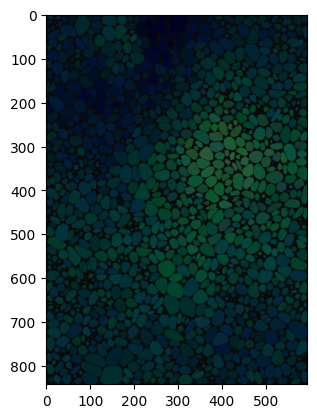

In [103]:
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, box
from shapely import offset_curve
import cv2 as cv
import seaborn as sns

height = 842
width = 595

n_points = 1200

import matplotlib.pyplot as plt

# Generate random points
points = np.random.rand(n_points, 2) * [width, height]
points = np.append(points, [[9999,9999], [-9999,9999], [9999,-9999], [-9999,-9999]], axis = 0)
# Compute Voronoi diagram
vor = Voronoi(points)
# Get centroids of Voronoi polygons
def get_polygons(vor):
    polygons = []
    for region in vor.regions:
        if (len(region) > 2) and (not -1 in region):
            polygon = [vor.vertices[i] for i in region]
            polygon.append(polygon[0])
            polygons.append(np.array(polygon))
    return polygons

polygons = get_polygons(vor)

# Define the bounding box
bounding_box = box(0, 0, width, height)

# Clip polygons to the bounding box
clipped_polygons = [Polygon(polygon).intersection(bounding_box) for polygon in polygons]

def rounded_corners(polygon, radius=20):
    #new_polygon = polygon.buffer(-2*radius, join_style='bevel', cap_style='round').buffer(radius, join_style='round', cap_style='round')
    new_polygon = polygon.buffer(radius, join_style='bevel', cap_style='round').buffer(-radius, join_style='round', cap_style='round')
    return new_polygon

clipped_polygons = [rounded_corners(polygon).buffer(-1) for polygon in clipped_polygons]
clipped_polygons = [polygon for polygon in clipped_polygons if not polygon.is_empty]
centroids = [polygon.centroid.coords[0] for polygon in clipped_polygons]
clipped_polygons = [np.stack(polygon.exterior.coords.xy, axis=-1) for polygon in clipped_polygons]


img = np.ones((height, width, 3), np.uint8) * 100

# Define colors for each quarter
n = 6
palette = sns.color_palette("crest", n, )
colors = np.array(palette) * 255

positions_x = np.random.randint(0, width, (n, 1))
positions_y = np.random.randint(0, height, (n, 1))
positions = np.concatenate([positions_x, positions_y], axis=1)

size = (width+height)/2
ratios = np.array([10,1,0])
ratios = ratios / sum(ratios)
# Calculate color for each polygon based on distance to each color point
for i, polygon in enumerate(clipped_polygons):
    centroid = centroids[i]
    distances = [1/(np.linalg.norm(np.array(centroid) - np.array(pos), ord=1)/size)**2 for pos in positions]
    total_distance = sum(distances)
    weights = [d / total_distance for d in distances]
    avg_color = np.average(colors, axis=0, weights=weights).astype(float)
    rnd_color = np.random.randint(0, 255, 3)
    max_color = colors[np.argmax(weights)]
    color = np.sum(np.array([avg_color, rnd_color, max_color])*ratios[:,np.newaxis], axis=0)
    cv.fillPoly(img, [polygon.astype(int)], color=tuple(color.astype(float)))

#for polygon in clipped_polygons:
#    cv.fillPoly(img, [polygon.astype(int)], (0,0,0))
dark_img = np.ones((height, width, 3), np.uint8) * 90
img = cv.subtract(img, dark_img)
plt.imshow(img)

cv.imwrite('voronoi.png', img[...,::-1], [cv.IMWRITE_JPEG_QUALITY, 100])

In [107]:
n_k = 1/16
kernel = np.array([[n_k, n_k, n_k],[n_k,0.5,n_k],[n_k,n_k,n_k]],np.float32)
img = cv.filter2D(img,-1,kernel)
cv.imwrite('voronoi.png', img[...,::-1], [cv.IMWRITE_JPEG_QUALITY, 100])

True

255


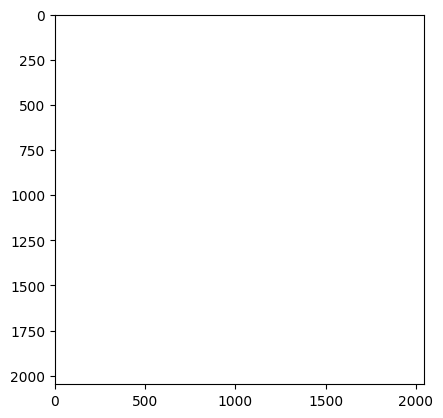

In [ ]:
img = cv.imread('resources/fzzyfoxx_logo_transparent.png', cv.IMREAD_UNCHANGED)
# Convert the image to BGRA (Blue, Green, Red, Alpha) format
img_bgra = cv.cvtColor(img, cv.COLOR_BGR2BGRA)
print(np.max(img_bgra[:, :, 3]))
# Create a mask where the alpha channel is greater than 0 (i.e., not transparent)
mask = img_bgra[:, :, 3] > 0

# Set the foreground to white where the mask is true
img_bgra[mask] = [255,255,255,255]

# Convert back to BGR format for displaying with matplotlib
#img = cv.cvtColor(img_bgra, cv.COLOR_BGRA2BGRA)
cv.imwrite('white_logo.png', img_bgra)
plt.imshow(img_bgra)

In [22]:
img = cv.imread('resources/fzzyfoxx_logo_transparent.png', cv.IMREAD_UNCHANGED)
# Convert the image to BGRA (Blue, Green, Red, Alpha) format
img_bgra = cv.cvtColor(img, cv.COLOR_BGR2BGRA)
# Resize the image to a specific size (e.g., 100x100)
resized_img = cv.resize(img_bgra, (256, 256))
# Convert from BGRA to RGBA
#resized_img = cv.cvtColor(resized_img, cv.COLOR_BGRA2RGBA)
# Save the resized image
cv.imwrite('resized_fzzyfoxx_logo.png', resized_img)

True

In [138]:
import fitz
doc = fitz.open("output.pdf")
numpages = doc.page_count  # number of pages
blue = fitz.pdfcolor["blue"]
img_size = 50
padding = 5

for page in doc:
    prect = page.rect
    center = prect.width/2
    header_rect = fitz.Rect(center-img_size/2, padding, center+img_size/2, padding+img_size)  # height 20 points
    page.insert_image(header_rect, filename='fzzyfoxx_logo_transparent.png')

    ftext = str(page.number + 1)
    y1 = prect.height - 20  # bottom of footer rect
    y0 = y1 - 20  # top of footer rect
    footer_rect = fitz.Rect(0, y0, prect.width, y1)  # rect has full page width
    page.insert_textbox(footer_rect, ftext, align=fitz.TEXT_ALIGN_CENTER, fontsize=8)

doc.save("output-numbered.pdf")

In [ ]:
import fitz

def concatenate_pdfs(pdf_paths, output_path):
    # Create a new PDF document
    output_pdf = fitz.open()

    # Iterate through the list of PDF paths
    for pdf_path in pdf_paths:
        # Open the current PDF
        current_pdf = fitz.open(pdf_path)
        
        # Append each page of the current PDF to the output PDF
        for page_num in range(len(current_pdf)):
            output_pdf.insert_pdf(current_pdf, from_page=page_num, to_page=page_num)
    
    # Save the concatenated PDF to the specified output path
    output_pdf.save(output_path)
    print(f"Concatenated PDF saved to: {output_path}")

# Example usage
pdf_paths = ["file1.pdf", "file2.pdf", "file3.pdf"]
output_path = "concatenated_output.pdf"
concatenate_pdfs(pdf_paths, output_path)

In [127]:
prect.width

595.0

In [118]:
pdf_path = "output.pdf"
pdf_document = fitz.open(pdf_path)

page = pdf_document.load_page(0)
text = page.get_text("text")

In [123]:
page.get_text_blocks()

[(72.0,
  80.07196807861328,
  509.97222900390625,
  99.26323699951172,
  '3.1.1 Introduction to Chain-of-Thought (CoT) Prompting - Unlocking Reasoning Abilities in Large\nLanguage Models\n',
  0,
  0),
 (72.0,
  108.23127746582031,
  518.4607543945312,
  150.864501953125,
  'Large Language Models (LLMs) have demonstrated impressive capabilities in various natural language tasks, from text\ngeneration to translation. However, their ability to perform complex reasoning and problem-solving has often been limited when\nusing standard prompting techniques. Enter Chain-of-Thought (CoT) prompting, a revolutionary approach that unlocks the latent\nreasoning potential within these models. This subchapter introduces the core principles of CoT prompting, explaining its\nrationale, benefits, and workflow, and contrasting it with traditional prompting methods.\n',
  1,
  0),
 (72.0,
  158.37530517578125,
  257.41845703125,
  166.42645263671875,
  'Definition of Chain-of-Thought (CoT) Prompting\n',

# Graph responses

In [56]:
import re

a = "asdklasf <<abc def ghi>> asdfasf <<graph2>>"

def extract_text_between_signs(text):
    pattern = r'<<(.+?)>>'
    matches = re.findall(pattern, text)
    return matches

graph_description_list = extract_text_between_signs(content_response)
print(graph_description_list)

['graph_description: A bar graph showing the performance (accuracy) of a few-shot CoT model on a specific task with three different example orderings: "Simple to Complex", "Random", and "Interleaved". The "Simple to Complex" ordering shows the highest accuracy, followed by "Interleaved", and then "Random". The X-axis represents the example ordering, and the Y-axis represents the accuracy score.']


In [57]:
system = """You are a specialist in graphviz python library. On every request you create a list of edges for a graph."""

task = """Create a list graph edges using following description:
{graph_description}
Answer in json format using following structure:
[{{"source": "A", "target": "B", "label": "relation_description"}}, {{"source": "B", "target": "C", "label": "relation_description"}}]
"""

chat_prompt = ChatPromptTemplate([
                    {"role": "system", "content": system},
                    {"role": "user", "content": task}
                ])

chain_inputs = [{"graph_description": graph_description} for graph_description in graph_description_list]

chain = chat_prompt | llm | guide_builder._parse_json

graph_response = chain.batch(chain_inputs)

In [58]:
graph_response

[[{'source': 'Simple to Complex', 'target': 'Accuracy', 'label': 'shows'},
  {'source': 'Random', 'target': 'Accuracy', 'label': 'shows'},
  {'source': 'Interleaved', 'target': 'Accuracy', 'label': 'shows'},
  {'source': 'Simple to Complex',
   'target': 'Interleaved',
   'label': 'higher accuracy than'},
  {'source': 'Interleaved',
   'target': 'Random',
   'label': 'higher accuracy than'}]]

In [59]:
from graphviz import Digraph

dot = Digraph()
dot.attr(rankdir='LR')
dot.node_attr.update(fontsize='10')
for edge in graph_response[0]:
    dot.edge(edge['source'], edge['target'], label=edge['label'])

dot.render('./graph_renders/test', format='png', view=False)

'graph_renders/test.png'